In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt


In [ ]:

!nvidia-smi

Thu Jul 31 20:13:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             48W /  400W |    1855MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Setup Device-Agnostic Code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Set the seed

torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)


In [ ]:
# Settiing the hyperparameters
BATCH_SIZE = 128
EPOCHS = 70
LEARNING_RATE = 3e-4
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
PATCH_SIZE = 4
NUM_CLASSES = 10
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1
PATCH_SIZE = 4


In [ ]:
#Define Image Transformations

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                # Helps the model to converge faster and computations stable.
                                ])



In [ ]:
# Datasets

train_dataset = datasets.CIFAR10(root = "data", train=True, download=True, transform=transform )


In [ ]:
test_dataset = datasets.CIFAR10(root = "data", train=False, download=True, transform=transform )

In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
# Datasets into Dataloaders
# DataLoader turns the data into batches or mini-batches.


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [ ]:
# Checking

print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7b762e52fbd0>, <torch.utils.data.dataloader.DataLoader object at 0x7b769073a210>)
Length of train_loader: 391 batches of 128
length of test_loader: 79 batches of 128


Building ViT from scratch

In [ ]:
# ViT


class PatchEmbedding(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               in_channels,
               embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels=embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size // patch_size)**2
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))


  def forward(self, x:torch.Tensor):
    B = x.size(0)
    x = self.proj(x) #(B, E, H/P, W/P)
    x = x.flatten(2).transpose(1,2) #(B, N, E)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embed
    return x

In [ ]:
# Multilayer Percetions

class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features,
                         out_features=hidden_features)
    self.fc2 = nn.Linear(in_features=hidden_features,
                        out_features=in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x

In [ ]:
# Transformer Encoder layer


class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(
        *[TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
        for _ in range(depth)
    ])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)


  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    return self.head(cls_token)



In [ ]:
# MODEL


model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)


In [ ]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

Defining Loss funtion and an optimizer.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)

In [ ]:
criterion

CrossEntropyLoss()

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

Training Loop Function

In [ ]:


def train(model, loader, optimizer, criterion):
  # Set the mode of the model of the into training
  model.train()

  total_loss, correct = 0, 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)     # Moving data to the target device
    optimizer.zero_grad()
    out = model(x)                 #  forward pass (mode outputs)
    loss = criterion(out, y)       #  calculate loss per batch
    loss.backward()                #  Backpropagation
    optimizer.step()               #  perform gradient descent

    total_loss += loss.item()*x.size(0)
    correct += (out.argmax(1) == y).sum().item()    # This counts how many predictions in the batch are correct. You keep adding that to correct to get total correct predictions across the epoch.

  return total_loss / len(loader.dataset), correct / len(loader.dataset)   # Normalizing lossacroll all batches







In [ ]:
def evaluate(model, loader):
  model.eval()  # Set the mode of the model to evaluation
  correct = 0
  with torch.inference_mode():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)





In [ ]:
from tqdm.auto import tqdm

In [ ]:
# TRAINING

train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss: .4f}, Train acc: {train_acc: .4f}%, Test acc: {test_acc: .4f}")






  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 1/70, Train loss:  1.7363, Train acc:  0.3714%, Test acc:  0.4722
Epoch: 2/70, Train loss:  1.3797, Train acc:  0.5042%, Test acc:  0.5384
Epoch: 3/70, Train loss:  1.2347, Train acc:  0.5581%, Test acc:  0.5748
Epoch: 4/70, Train loss:  1.1230, Train acc:  0.6004%, Test acc:  0.5924
Epoch: 5/70, Train loss:  1.0336, Train acc:  0.6334%, Test acc:  0.6099
Epoch: 6/70, Train loss:  0.9627, Train acc:  0.6569%, Test acc:  0.6108
Epoch: 7/70, Train loss:  0.8859, Train acc:  0.6844%, Test acc:  0.6175
Epoch: 8/70, Train loss:  0.8137, Train acc:  0.7079%, Test acc:  0.6280
Epoch: 9/70, Train loss:  0.7379, Train acc:  0.7360%, Test acc:  0.6320
Epoch: 10/70, Train loss:  0.6681, Train acc:  0.7625%, Test acc:  0.6383
Epoch: 11/70, Train loss:  0.6049, Train acc:  0.7830%, Test acc:  0.6412
Epoch: 12/70, Train loss:  0.5341, Train acc:  0.8100%, Test acc:  0.6315
Epoch: 13/70, Train loss:  0.4786, Train acc:  0.8294%, Test acc:  0.6346
Epoch: 14/70, Train loss:  0.4203, Train acc:  

In [ ]:
train_accuracies

[0.37144,
 0.50422,
 0.55812,
 0.6004,
 0.63338,
 0.65694,
 0.68444,
 0.70786,
 0.736,
 0.76252,
 0.78304,
 0.81,
 0.82936,
 0.8512,
 0.86666,
 0.88344,
 0.89582,
 0.90866,
 0.91316,
 0.9222,
 0.92952,
 0.93062,
 0.93896,
 0.94162,
 0.94198,
 0.94878,
 0.95126,
 0.95132,
 0.95482,
 0.95696,
 0.95752,
 0.95668,
 0.9603,
 0.96142,
 0.96316,
 0.96268,
 0.9623,
 0.96486,
 0.9676,
 0.9667,
 0.96702,
 0.9679,
 0.96784,
 0.96574,
 0.96962,
 0.97058,
 0.97204,
 0.9708,
 0.97082,
 0.9726,
 0.9746,
 0.97298,
 0.97128,
 0.97322,
 0.9752,
 0.9761,
 0.975,
 0.97524,
 0.97348,
 0.97816,
 0.97824,
 0.9782,
 0.9784,
 0.97692,
 0.97754,
 0.97978,
 0.97888,
 0.97758,
 0.97822,
 0.98004]

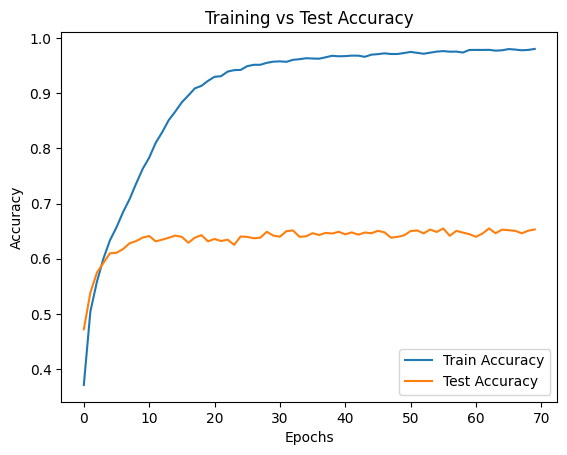

In [ ]:
# Plot accuracy

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Test Accuracy")
plt.show()



In [ ]:
print(f"Test dataset length: {len(test_dataset)}")

Test dataset length: 10000


In [ ]:
test_dataset[0][0].unsqueeze(dim=0).shape

torch.Size([1, 3, 32, 32])

>>> Before function call


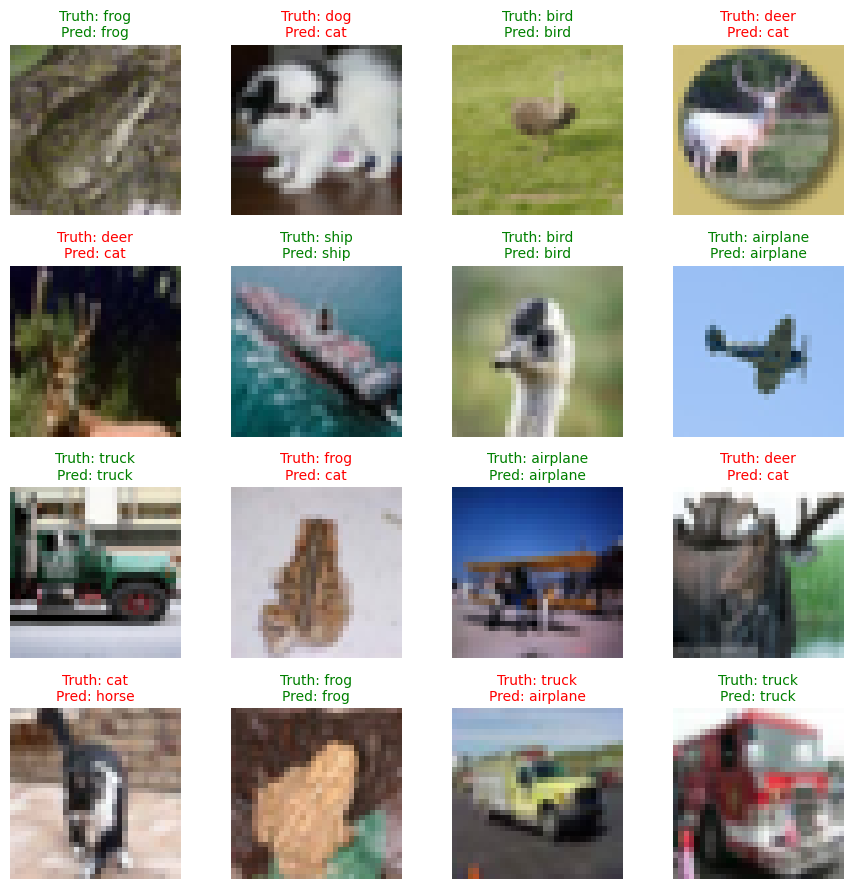

>>> After function call


In [ ]:

import random
import torch
import matplotlib.pyplot as plt


print(">>> Before function call")
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=4)
print(">>> After function call")


# Unnormalize function

def unnormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(img_tensor.device)

    return img_tensor * std + mean



def predict_and_plot_grid(model, dataset, classes, grid_size=3):
    model.eval()

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset)-1)
            img, true_label = dataset[idx]


            input_tensor = img.unsqueeze(0).to(device)


            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)



            img = unnormalize(img)

            img = img.clamp(0, 1)
            img = img.permute(1, 2, 0).cpu().numpy()

            truth = classes[true_label] == classes[predicted.item()]
            color = "g" if truth else "r"

            axes[i, j].imshow(img)
            axes[i, j].set_title(f"Truth: {classes[true_label]}\nPred: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()









In [ ]:
img, label = test_dataset[0]
print(img.shape)


torch.Size([3, 32, 32])


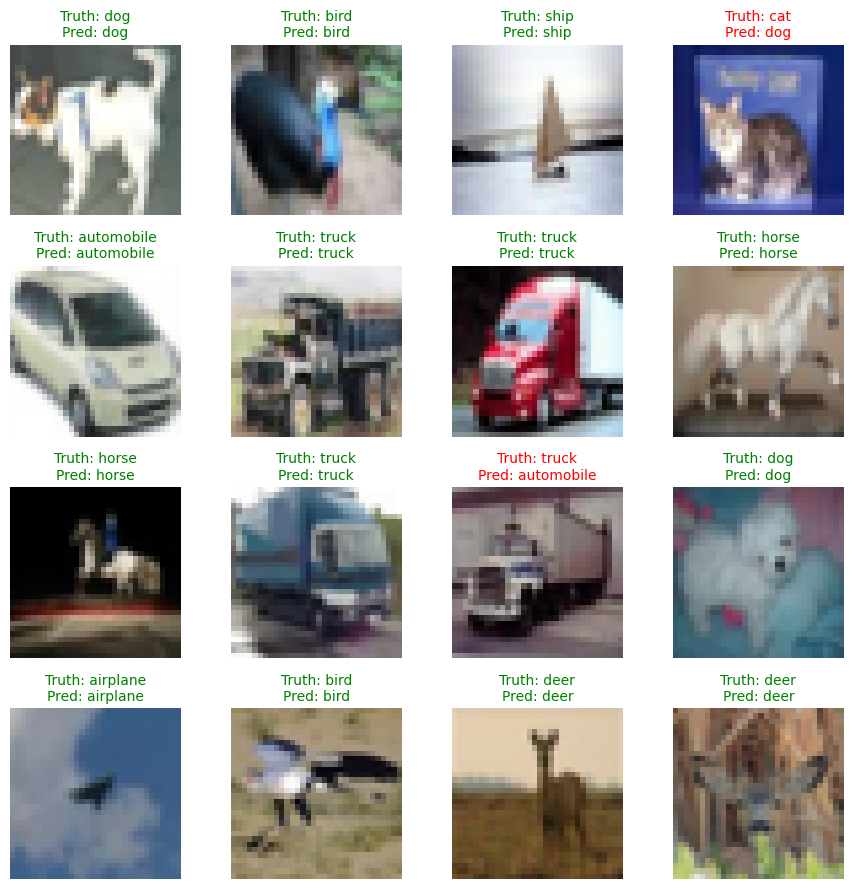

In [ ]:

predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=4)

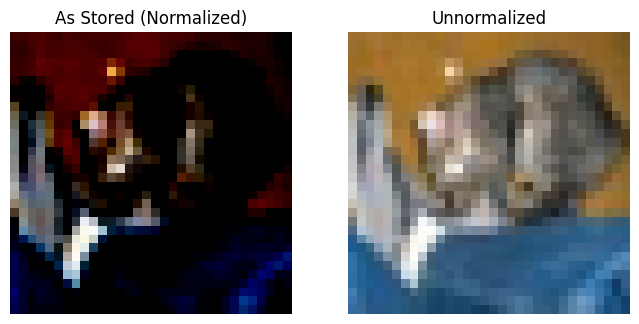

In [ ]:
import matplotlib.pyplot as plt

img, label = test_dataset[0]

# Normalized image (as it is stored)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))  # just clamped for now
plt.title("As Stored (Normalized)")
plt.axis("off")

# Unnormalized
img_unnorm = img * 0.5 + 0.5  # since mean=0.5, std=0.5
plt.subplot(1, 2, 2)
plt.imshow(img_unnorm.permute(1, 2, 0).clamp(0, 1))
plt.title("Unnormalized")
plt.axis("off")
plt.show()


In [ ]:
!pip install nbstripout
!nbstripout ViT_from_scratch_on_CIFAR_10_PyTorch.ipynb


Could not strip 'ViT_from_scratch_on_CIFAR_10_PyTorch.ipynb': file not found
